In [1]:
import scanpy as sc
import squidpy as sq
import os

In [2]:
sys.path.append('/home/augusta/SSS_mount/insituCNV/InSituCNV/modules')
sys.path

['/home/augusta/SSS_mount/insituCNV/InSituCNV/Figure2/01_Simulate_CNVs_in_spatial_data/Simulate_CNVs',
 '/home/augusta/SSS_mount/mymodules',
 '/home/augusta/anaconda3/envs/scanpy_env/lib/python312.zip',
 '/home/augusta/anaconda3/envs/scanpy_env/lib/python3.12',
 '/home/augusta/anaconda3/envs/scanpy_env/lib/python3.12/lib-dynload',
 '',
 '/home/augusta/anaconda3/envs/scanpy_env/lib/python3.12/site-packages',
 '/home/augusta/SSS_mount/mymodules',
 '/home/augusta/SSS_mount/insituCNV/InSituCNV/modules']

# Load AnnData

In [3]:
adata_path = os.path.expanduser("~/SSS_mount/insituCNV/InSituCNV/Load_datasets/Lymph_Node/Xenium_HumanLymphNode_5K.h5ad")
adata = sc.read_h5ad(adata_path)

# Illustrate the genome coverage of the data (then make this into a module)

In [4]:
from plot_gene_coverage import *

In [5]:
gene_file = os.path.expanduser("~/SSS_mount/insituCNV/InSituCNV/Ensmbl_BioMart_gene_info.txt")

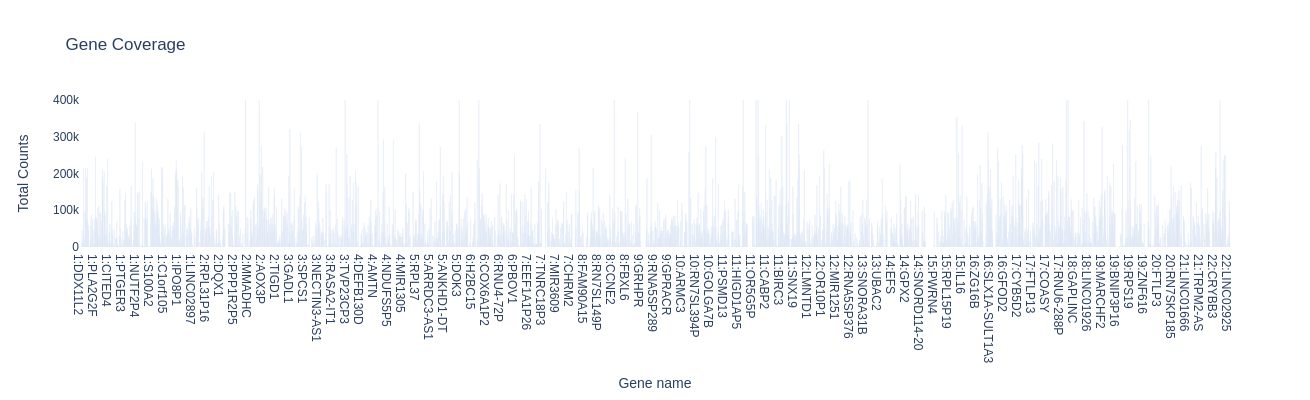

In [7]:
plot_gene_coverage(adata, count_max=400000, gene_identifyer= 'gene_ids', gene_info=gene_file)

# Simulate the data to contain CNVs

Divide the dataset into four simulated subclones

1.   Normal (unaltered)
2.   Subclone A (fewer CNVs)
3.   Subclone B (same as A but added)
4.   Subclone C (same as A but added)


Choose chromosomal regions to be duplicated or deleted

If we generate several CNVs throughout the genome, it might be possible to compare the detection efficiency as to how many of the CNVs are detected. Or else, it's works/not works.


Things to consider: 
- how the size (nbr of cells) of the subclone affect the outcome - or make same size populations and avoid adressing this
- choose the size of the CNVs
    - literature to find an appropriate size for CNVs (50bp - several Mbs, ref: https://doi.org/10.1016%2Fj.bj.2021.02.003)
    - different sizes to see how that affects the outcome - or make every CNV the same size


## Module to simulate CNVs in adata (simulate_CNVs.py)

In [5]:
from simulate_CNVs import *

### Function: Generate CNVs (generate_cnvs)

This function generates copy number variations (CNVs) based on a dictionary (**CNV_dict**) of genes (keys) and whether they should be gain or loss (value). The size (bp) of the CNV is a randomly chosen size between **min_size** and **max_size**. The gene will be in the center of the CNV, so half of the size (bp) is subtracted (start) and added (end) from the center of the gene position ('Gene end (bp)'- 'Gene start (bp)')/2), taken from the **gene_list**. The output will be a list of these CNVs, specifying the gene name, chromosome, size (bp), type (gain/loss), start (bp), end (bp).

Parameters:

- **CNV_dict** - dict. Gene name (key) and whether they should be 'gain' or 'loss'. Could for example be gain of known oncogenes or loss of tumor supressors. Gene selection inspo: https://doi.org/10.1080%2F07853890.2023.2280708
- **min_size** - nbr in bp.
- **max_size** - nbr in bp. A size of the CNV is generated as a random number between the min and max
- **gene_info** - the *Ensmbl_BioMart_gene_info.txt* containing 'Gene stable ID', 'Chromosome/scaffold name', 'Gene start (bp)', 'Gene end (bp)', 'Gene name'

Returns:

- **CNV_df** (DataFrame): Compiling the gene name, chromosome, size, type, start, end

In [6]:
CNV_dict = { 
    'DIS3': 'loss',
    'EPHB1': 'loss',
    'ERBB2': 'gain',
    'FLT1': 'gain',
    'HCK': 'gain',
    'KEAP1': 'loss',
    'MYD88': 'gain',
    'TBX3': 'gain'
}

min_size = 100
max_size = 1000000


gene_file = os.path.expanduser("~/SSS_mount/insituCNV/InSituCNV/Ensmbl_BioMart_gene_info.txt")

In [7]:
generate_cnvs(CNV_dict, min_size, max_size, gene_info=gene_file, save_csv='CNVs_v0.csv') 

,Gene name,Chromosome,Size (bp),Type,Start (bp),End (bp)
0,DIS3,13,611640,loss,72461312,73072952
1,EPHB1,3,157788,loss,134948969,135106757
2,ERBB2,17,468662,gain,39474839,39943501
3,FLT1,13,164754,gain,28315368,28480122
4,HCK,20,240518,gain,31956767,32197285
5,KEAP1,19,704858,loss,10142412,10847270
6,MYD88,3,812127,gain,37734725,38546851
7,TBX3,12,808520,gain,114272955,115081475


### Function: Create CNV template (create_cnv_template)

This function generates a CNV template for an AnnData object based on a predifined number of subclones, and their CNVs, generated by the generate_cnvs function.  

Parameters:

- **adata** - the AnnData object
- **CNV_df** (DataFrame): from the *'Generate CNVs'* module. the gene name, chromosome, size, type, start, end - . The type should generate either -1/+1 depending on if it's 'gain' or 'loss'.

Returns:

- **cnv_template_df** (DataFrame). For each CNV (gene name) - generate an array with -1/0/1 values for each gene in the adata.var_names

In [9]:
CNV_df = generate_cnvs(CNV_dict, min_size, max_size, gene_info=gene_file) 

In [12]:
create_cnv_template(adata, CNV_df)

gene_names,HES4,TNFRSF18,PUSL1,DVL1,ATAD3A,PRKCZ,TNFRSF14,MMEL1,WRAP73,TP73,...,VEGFD,VSIG4,WAS,XIAP,ZBTB33,ZC4H2,ZFX,ZMYM3,ZNF280C,ZNF449
DIS3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPHB1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERBB2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FLT1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HCK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KEAP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MYD88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TBX3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Function: Simualte CNVs in the data (simulate_cnvs)

This function applies poission distribution / binomial probability to simulate one arm gains and losses (increase/keep/decrease the counts (adata.X) depending on the -1/0/1 value of the cnv_template_df: if -1, the probability is 0.5 and if 1 it is 1.5). This is done according to a subclone_dict, where each key is a subclone, and the values state which CNVs to add to these cells.  

Parameters:

- **adata** - the AnnData object to add the CNVs on
- **cnv_template_df** matrix. from the *'Create CNV template'* module
- **subclone_dict** (dictionary) For each subclone (key), a list of which CNVs to assign (values). randomly assigning each cell to one of these subclones (adata.obs.simulated_subclone)

Returns:

- **adata** - the AnnData object with simulated CNVs as a layer to the adata.X, (as well as the CNV template as a 'CNV_template' layer?)

In [10]:
cnv_template_df = create_cnv_template(adata, CNV_df)

subclone_dict = {
    'N': [], # Normal cells without CNV simulations
    'A': ['DIS3', 'EPHB1', 'ERBB2', 'FLT1'], # Original genetic subclone
    'B': ['DIS3', 'EPHB1', 'ERBB2', 'FLT1', 'HCK', 'KEAP1'], 
    'C': ['DIS3', 'EPHB1', 'ERBB2', 'FLT1', 'MYD88', 'TBX3'],
}

In [14]:
simulate_cnvs(adata, cnv_template_df, subclone_dict)

AnnData object with n_obs × n_vars = 708983 × 4624
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'leiden', 'simulated_subclone'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_names', 'chromosome', 'start', 'end'
    uns: 'group_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'CNV_simulated'
    obsp: 'connectivities', 'distances'

In [18]:
adata

AnnData object with n_obs × n_vars = 708983 × 4624
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'leiden', 'simulated_subclone'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_names', 'chromosome', 'start', 'end'
    uns: 'group_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'CNV_simulated'
    obsp: 'connectivities', 'distances'

In [20]:
adata.write("Xenium_HumanLymphNode_5K_simulatedCNVs.h5ad", compression = 'gzip')